# Étape 1 — Chargement et exploration initiale

(116, 10)
   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   

     MCP.1  Classification  
0  417.114               1  
1  468.786               1  
2  554.697               1  
3  928.220               1  
4  773.920               1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  

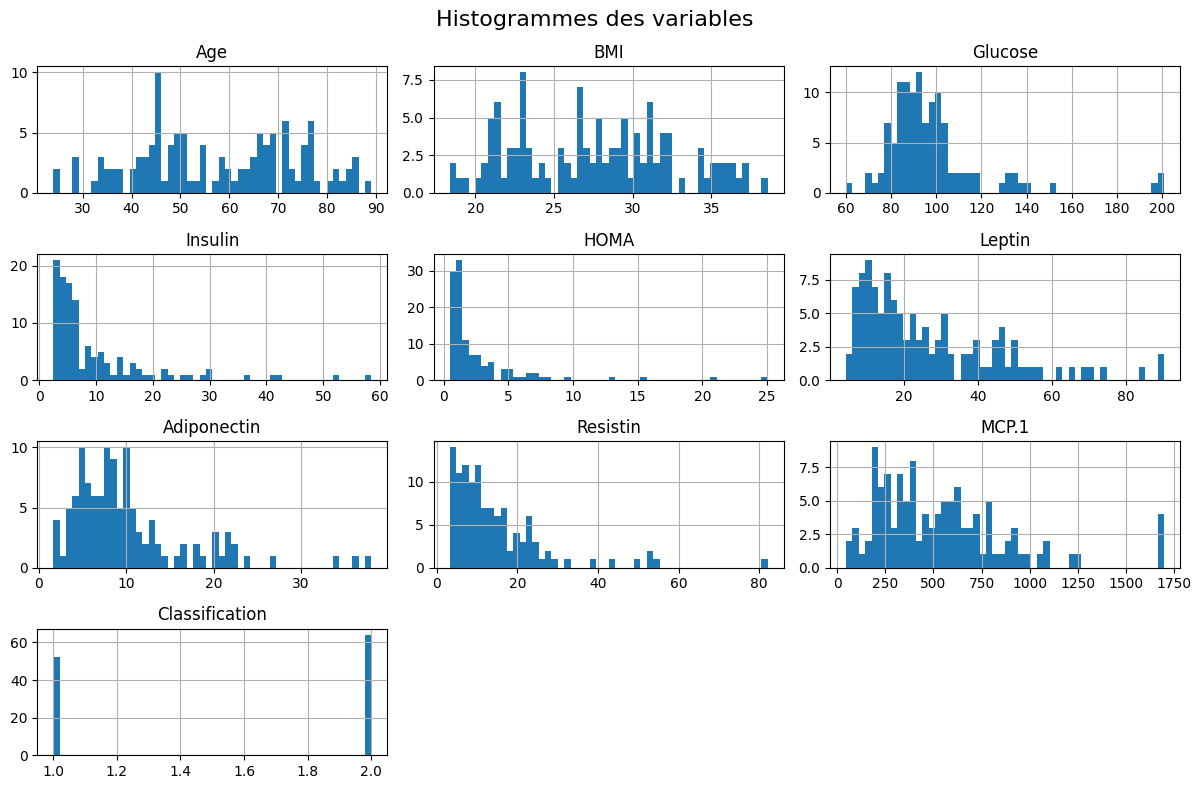

In [1]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
data = pd.read_csv('breast+cancer+coimbra/dataR2.csv')

# Aperçu des données
print(data.shape)
print(data.head())
data.info()

# Liste des variables explicatives
features = data.columns[:-1]
print("Les variables explicative sont :", list(features))
target = 'Classification'

# Histogrammes des variables
data.hist(bins=50, figsize=(12, 8))
plt.suptitle("Histogrammes des variables", fontsize=16)
plt.tight_layout()
plt.show()


# Étape 2 — Split du dataset en train et test


In [2]:
from sklearn.model_selection import train_test_split
# Séparation des features et de la cible
X = data.drop(columns='Classification')
y = data['Classification'].map({2: 0, 1: 1})

# Split stratifié pour préserver la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

# Vérification de la forme
print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)


Train : (92, 9) (92,)
Test  : (24, 9) (24,)


# Étape 3 — Visualisation des distributions par classe du dataset d'entrainement

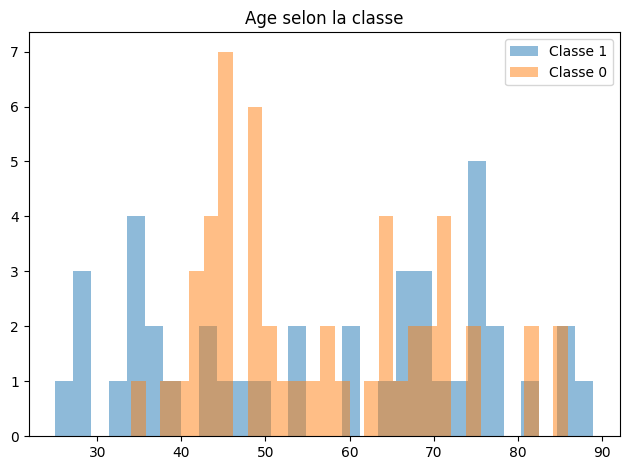

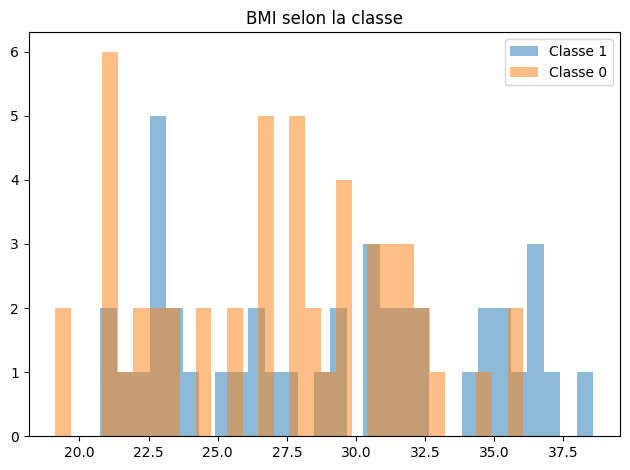

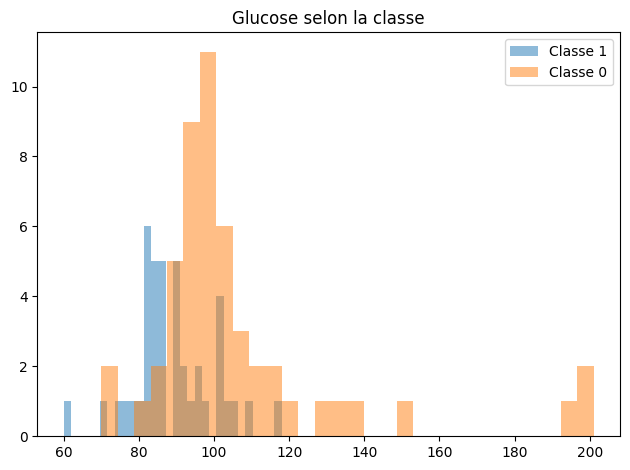

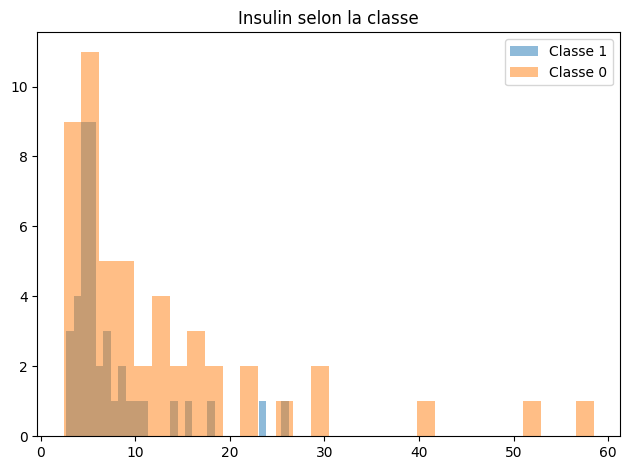

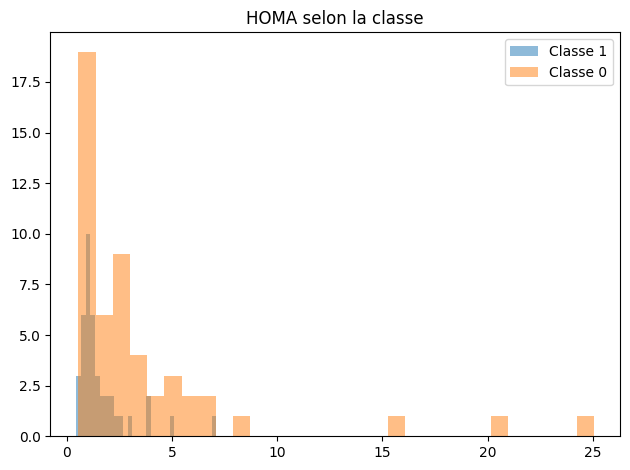

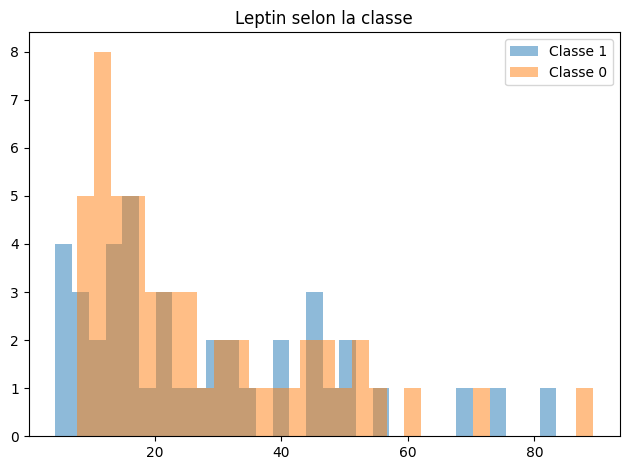

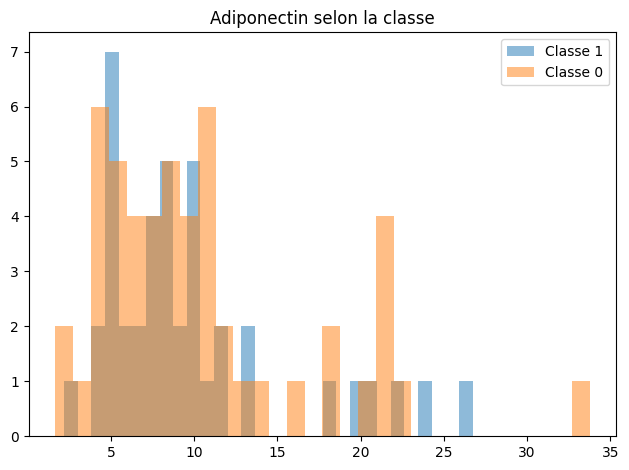

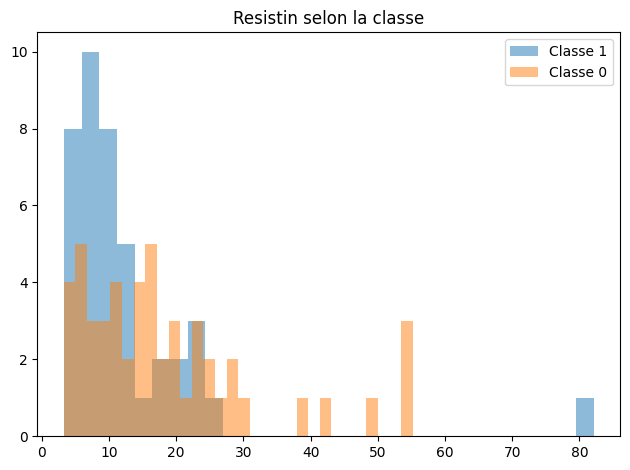

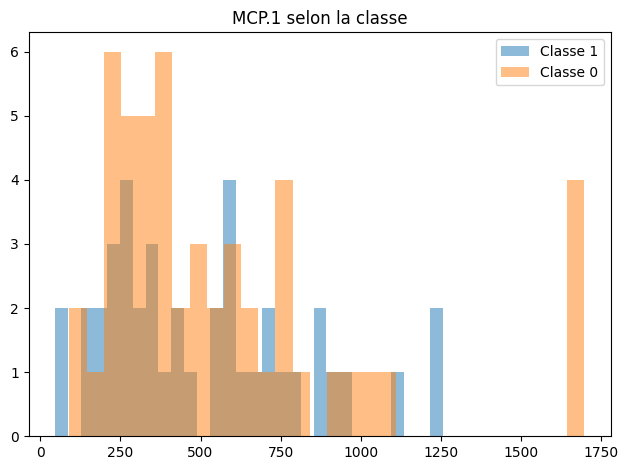

In [3]:
# Fusion temporaire pour affichage
train_data = X_train.copy()
train_data['Classification'] = y_train

# Histogrammes par classe pour chaque variable
# Afficher les histogrammes par classe pour chaque variable
for col in X_train.columns:
    plt.figure()
    for classe in y_train.unique():
        plt.hist(X_train[y_train == classe][col], bins=30, alpha=0.5, label=f"Classe {classe}")
    plt.title(f"{col} selon la classe")
    plt.legend()
    plt.tight_layout()
    plt.show()



# Étape 4 — Matrice de corrélation et scatter matrix (train uniquement)

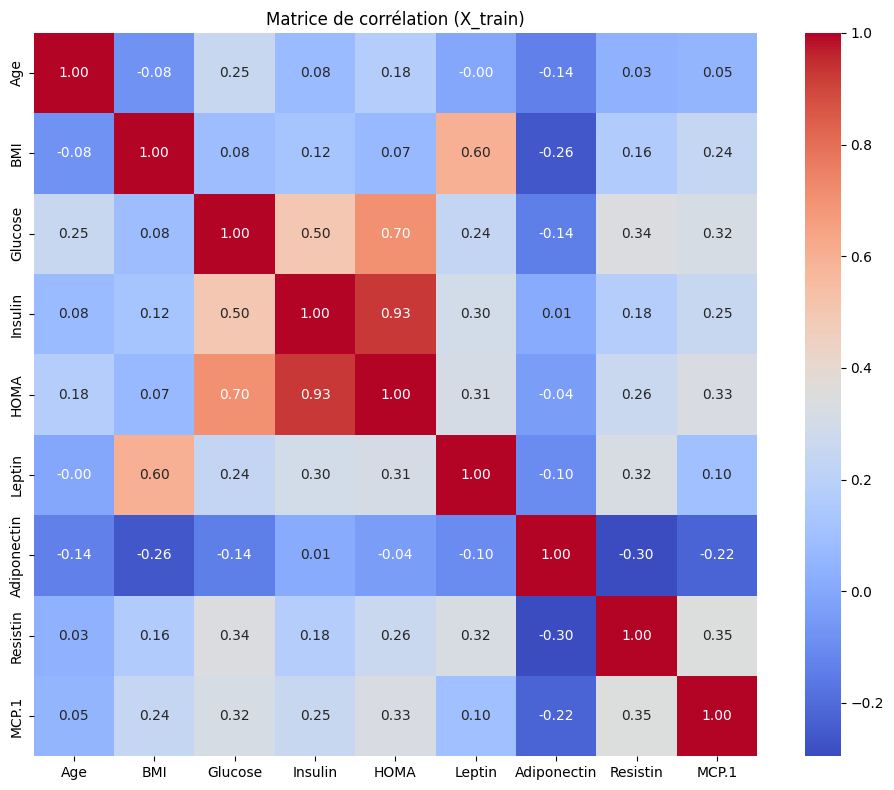

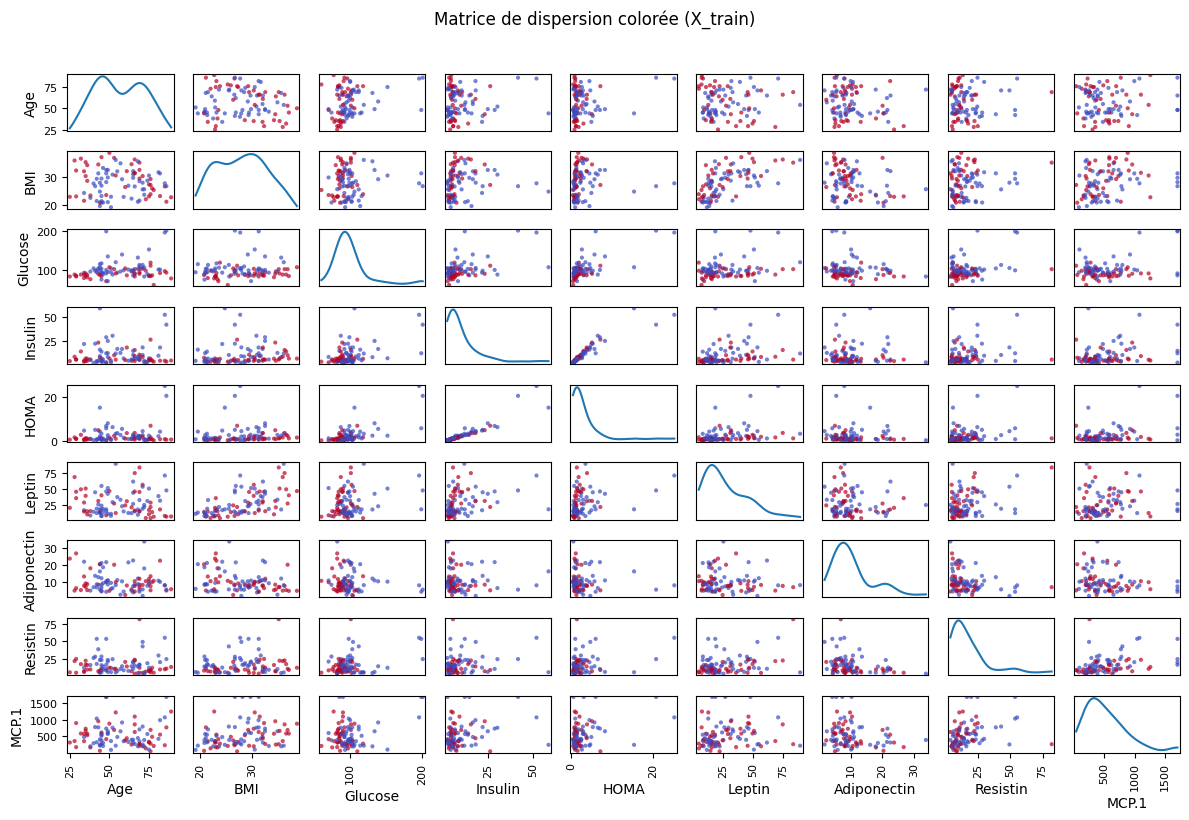

In [4]:
from pandas.plotting import scatter_matrix
# Matrice de corrélation (sur les données d'entraînement)
corr_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matrice de corrélation (X_train)")
plt.tight_layout()
plt.show()

# DataFrame combiné pour visualisation colorée
X_train_visu = X_train.copy()
X_train_visu['Classification'] = y_train.values

# Scatter matrix colorée
scatter_matrix(X_train_visu.drop(columns='Classification'),
               figsize=(12, 8),
               diagonal='kde',
               c=X_train_visu['Classification'],
               cmap='coolwarm',
               alpha=0.7)
plt.suptitle("Matrice de dispersion colorée (X_train)", y=1.02)
plt.tight_layout()
plt.show()



# Étape 5 — Transformation logarithmique 

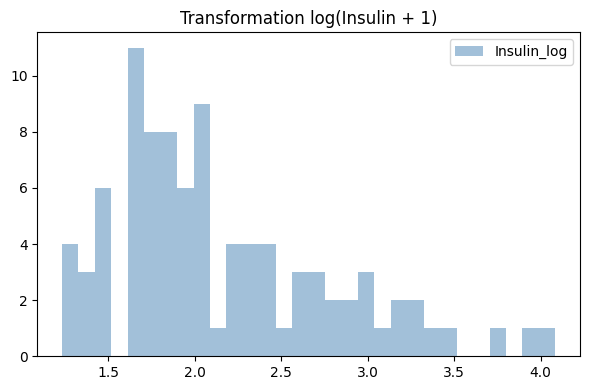

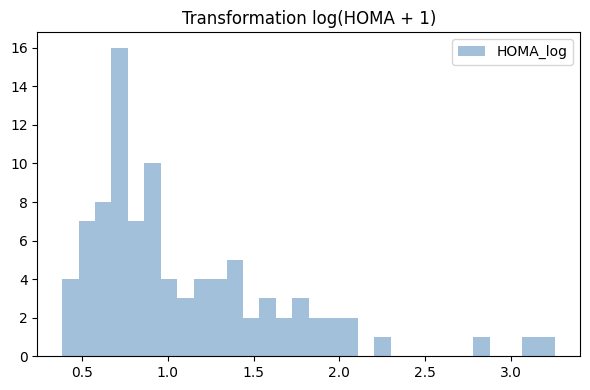

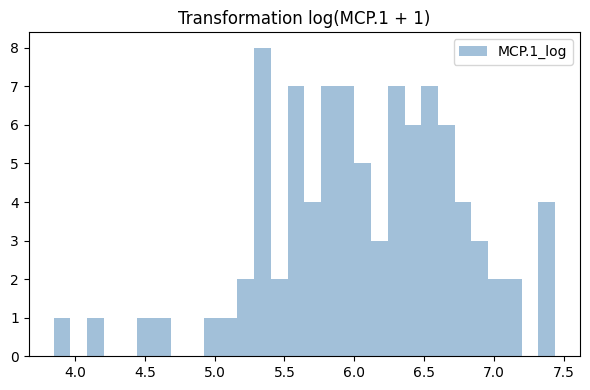

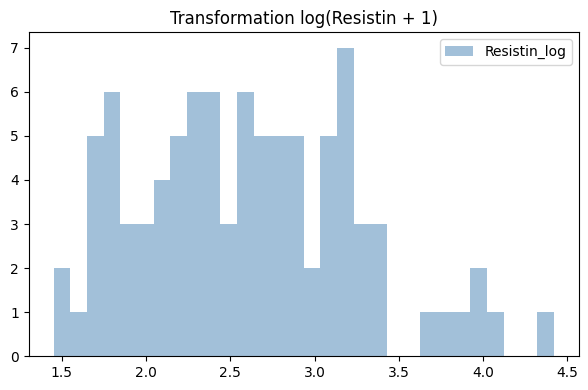

In [5]:
# Variables à transformer (forte asymétrie identifiée précédemment) 
variables_log = ['Insulin', 'HOMA', 'MCP.1', 'Resistin']

# Copie de X_train pour transformation
X_train_transformed = X_train.copy()

# Transformation log(x + 1)
for col in variables_log:
    X_train_transformed[col + '_log'] = np.log1p(X_train_transformed[col])
    
# Suppression des colonnes d'origine (optionnelle mais recommandée)
X_train_transformed = X_train_transformed.drop(columns=variables_log)

# Mise à jour de la liste des variables
features = X_train_transformed.columns.tolist()

for col in variables_log:
    plt.figure(figsize=(6, 4))
    plt.hist(np.log1p(X_train[col]), bins=30, alpha=0.5, label=f'{col}_log', color='steelblue')
    plt.title(f"Transformation log({col} + 1)")
    plt.legend()
    plt.tight_layout()
    plt.show()



# Étape 6 — Standardisation (StandardScaler)

In [6]:
from sklearn.preprocessing import StandardScaler

# Initialisation du scaler
scaler = StandardScaler()

# Entraînement du scaler sur le jeu transformé
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_transformed),
    columns=X_train_transformed.columns,
    index=X_train_transformed.index
)

X_train_scaled.describe().T[['mean', 'std']]


,mean,std
Age,1.037817e-16,1.005479
BMI,-8.447349e-17,1.005479
Glucose,1.995309e-16,1.005479
Leptin,6.033821e-17,1.005479
Adiponectin,1.436049e-16,1.005479
Insulin_log,2.292852e-16,1.005479
HOMA_log,-3.891814e-16,1.005479
MCP.1_log,-7.406515e-16,1.005479
Resistin_log,-1.680419e-16,1.005479


# Étape 7 — Préparation de X_test

In [7]:
# Copie de X_test
X_test_transformed = X_test.copy()

# Appliquer les mêmes log-transforms
for col in variables_log:
    X_test_transformed[col + '_log'] = np.log1p(X_test_transformed[col])

# Supprimer les colonnes originales
X_test_transformed = X_test_transformed.drop(columns=variables_log)

# Standardiser avec le scaler déjà entraîné sur X_train
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_transformed),
    columns=X_test_transformed.columns,
    index=X_test_transformed.index
)

# Vérifie que les colonnes de X_test sont identiques (et dans le même ordre) à celles de X_train, pour éviter des erreurs de prédiction
if list(X_train_scaled.columns) != list(X_test_scaled.columns):
    print( "Mismatch between train and test columns")


# Étape 8 — Modélisation avec LogisticRegression

In [8]:
# Entraînement initial du modèle de régression logistique (sans régularisation explicite)

from sklearn.linear_model import LogisticRegression
# Initialisation du modèle
logreg_simple = LogisticRegression(random_state=42)

# Entraînement sur les données standardisées
logreg_simple.fit(X_train_scaled, y_train)

# Prédictions sur le test
y_pred = logreg_simple.predict(X_test_scaled)

# Évaluation des performances (jsp si c'est utile de faire ça ici)
print("Nombre de prédictions positives :", y_pred.sum())
print("Nombre réel de cas positifs dans y_test :", y_test.sum())



Nombre de prédictions positives : 12
Nombre réel de cas positifs dans y_test : 11


# Étape 9 — Validation croisée (cross-validation)

Validation croisée (10 folds)
F1-score moyen : 0.696 ± 0.187
Accuracy moyen : 0.731 ± 0.175


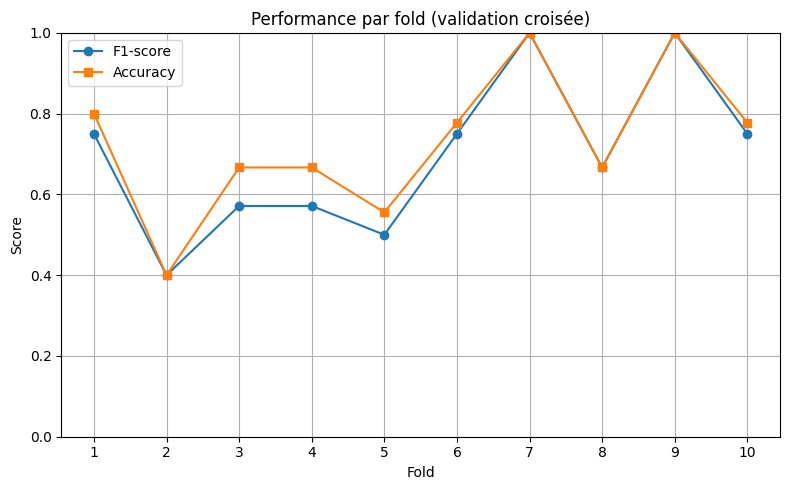

In [9]:
from sklearn.model_selection import cross_val_score

# Initialisation du modèle
logreg_cv = LogisticRegression(random_state=42)

# Validation croisée avec scoring F1
f1_scores = cross_val_score(logreg_cv , X_train_scaled, y_train, cv=10, scoring='f1')
acc_scores = cross_val_score(logreg_cv , X_train_scaled, y_train, cv=10, scoring='accuracy')

# Résumé
print("Validation croisée (10 folds)")
print(f"F1-score moyen : {f1_scores.mean():.3f} ± {f1_scores.std():.3f}") 
print(f"Accuracy moyen : {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")


# Visualisation des scores de validation croisée
folds = range(1, len(f1_scores) + 1)
plt.figure(figsize=(8, 5))
plt.plot(folds, f1_scores, marker='o', label='F1-score')
plt.plot(folds, acc_scores, marker='s', label='Accuracy')

plt.title("Performance par fold (validation croisée)")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(folds)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Afin d’évaluer la robustesse du modèle de régression logistique, nous avons effectué une validation croisée à 10 folds.  
Chaque fold permet d’entraîner le modèle sur 90 % des données d’entraînement, puis de l’évaluer sur les 10 % restants.

Nous avons suivi l’évolution du **F1-score** et de l’**accuracy** à chaque fold, ce qui permet d’observer la stabilité du modèle.

- Le **F1-score moyen** est de **0.696**, avec un écart-type de **0.187**
- L'**accuracy moyenne** est de **0.731**, avec un écart-type de **0.175**

Ces résultats montrent que le modèle présente des performances correctes mais **variables** selon la partition des données.  
Cette variabilité est attendue dans le cas d’un **petit jeu de données**, et justifie la suite de la démarche par une **optimisation via régularisation**.


# Étape 10 — Évaluation du modèle sur le test set

In [10]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : ", round(accuracy, 3))

# F1-score (binaire par défaut)
f1 = f1_score(y_test, y_pred)
print("F1-score :",round(f1, 3))

# Rapport complet
print("\nClassification Report :")
print(classification_report(y_test, y_pred))


Accuracy :  0.792
F1-score : 0.783

Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.75      0.82      0.78        11

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.80      0.79      0.79        24



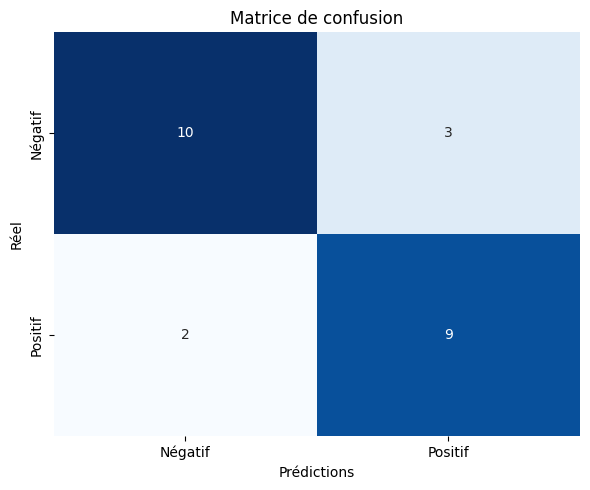


Coefficients du modèle :
        Feature  Coefficient
1           BMI     0.815422
0           Age     0.286680
5   Insulin_log     0.048883
3        Leptin     0.026291
7     MCP.1_log    -0.290218
4   Adiponectin    -0.301358
6      HOMA_log    -0.583908
8  Resistin_log    -0.700961
2       Glucose    -1.673655


/var/folders/kz/yn6r06915yl8rm1zpm_51j800000gn/T/ipykernel_67750/2534653591.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


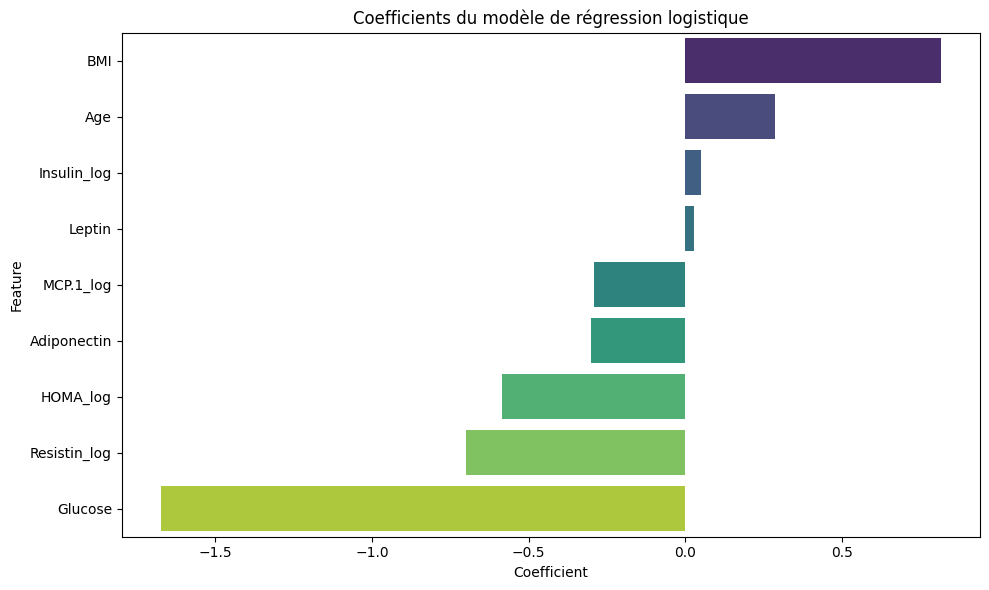

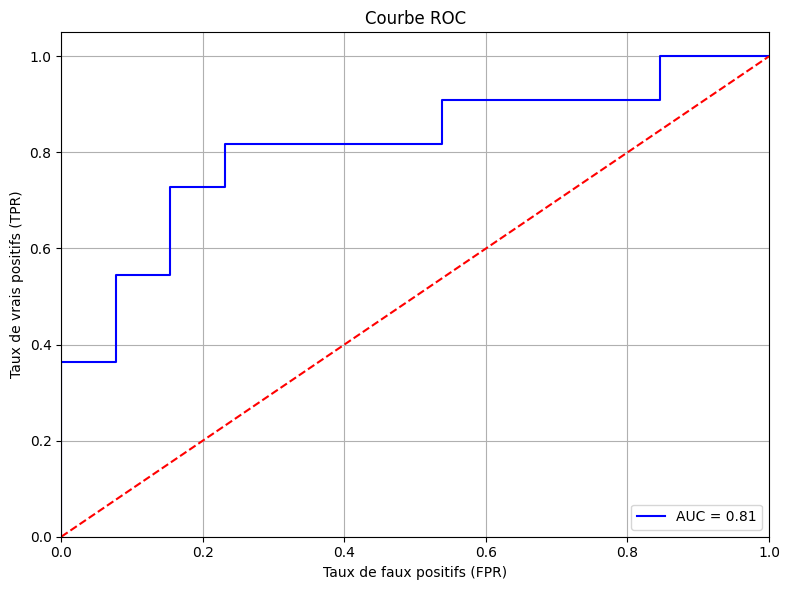

In [11]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


# Coefficients du modèle
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': logreg_simple.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nCoefficients du modèle :")
print(coefficients)
# Visualisation des coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title("Coefficients du modèle de régression logistique")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#Courbe ROC et AUC
from sklearn.metrics import roc_curve, auc
# Calcul des probabilités de prédiction
y_proba = logreg_simple.predict_proba(X_test_scaled)[:, 1]
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calcul de l'AUC
roc_auc = auc(fpr, tpr)  
# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonale
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

###  Analyse finale du modèle de régression logistique

L'évaluation complète du modèle sur le jeu de test montre des **résultats satisfaisants**, malgré la taille réduite du dataset :

-  **Matrice de confusion** : le modèle identifie correctement **9 cas positifs sur 11**, et limite les fausses alertes à **3 faux positifs**.
-  **Courbe ROC** : l'AUC atteint **0.81**, ce qui traduit une **bonne capacité de discrimination** entre patients atteints et non atteints.
-  **Analyse des coefficients** :
  - Les variables les plus influentes sont `BMI` (positif) et `Glucose` (négatif).
  - Cela donne une **lecture interprétable** du comportement du modèle.
-  **Équilibre des performances** : la **précision** et le **rappel** sont proches sur les deux classes, ce qui reflète un bon compromis.

Ces résultats montrent que la régression logistique, bien prétraitée (transformation + standardisation), permet d'obtenir un modèle à la fois **efficace** et **interprétable**, ce qui est essentiel dans un contexte biomédical.


# Étape 11: Régularisation

In [12]:
from sklearn.model_selection import GridSearchCV
# Grille d’hyperparamètres à tester
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']  # nécessaire pour l1
}
# Initialisation du modèle de régression logistique pour la recherche de grille
logreg_grid = LogisticRegression(random_state=42, max_iter=1000)

# Recherche de grille avec validation croisée
grid_search = GridSearchCV(logreg_grid, param_grid, cv=10, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

# Meilleur modèle
best_logreg = grid_search.best_estimator_

# Prédictions finales
y_pred_best = best_logreg.predict(X_test_scaled)

# Meilleurs paramètres
print("Best params :", grid_search.best_params_)
print("Best F1-score :", grid_search.best_score_)


print("\nÉvaluation sur le jeu de test :")
print("Accuracy :", round(accuracy_score(y_test, y_pred_best), 3))
print("F1-score :", round(f1_score(y_test, y_pred_best), 3))
print("\nClassification Report :")
print(classification_report(y_test, y_pred_best))



Best params : {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1-score : 0.7371428571428572

Évaluation sur le jeu de test :
Accuracy : 0.792
F1-score : 0.762

Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.80      0.73      0.76        11

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24



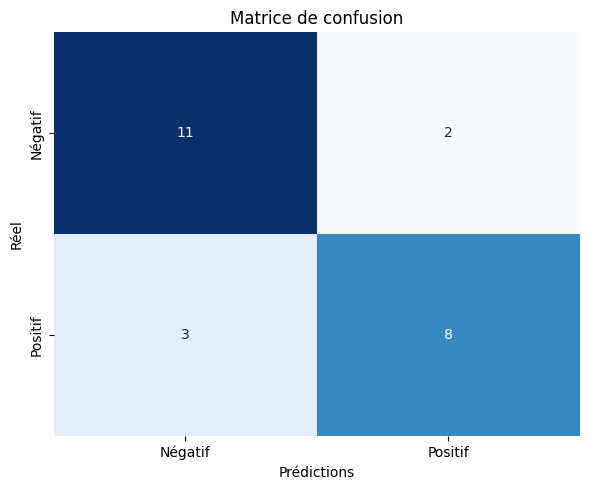


Coefficients du modèle :
        Feature  Coefficient
5   Insulin_log     2.661888
1           BMI     1.017807
0           Age     0.423608
3        Leptin    -0.014790
4   Adiponectin    -0.374322
7     MCP.1_log    -0.434532
8  Resistin_log    -0.844157
2       Glucose    -1.678957
6      HOMA_log    -3.778132


/var/folders/kz/yn6r06915yl8rm1zpm_51j800000gn/T/ipykernel_67750/3329826649.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


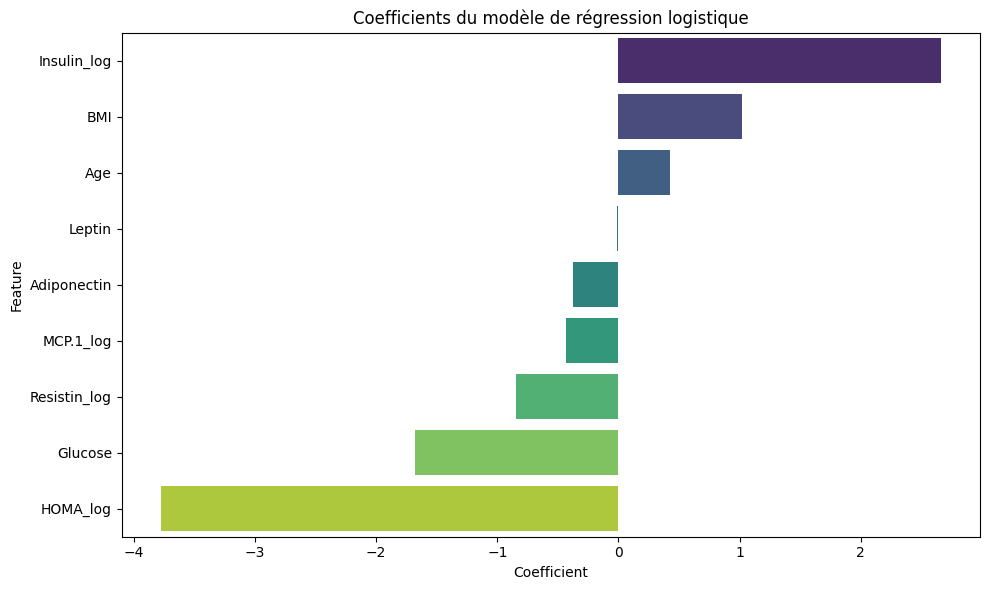

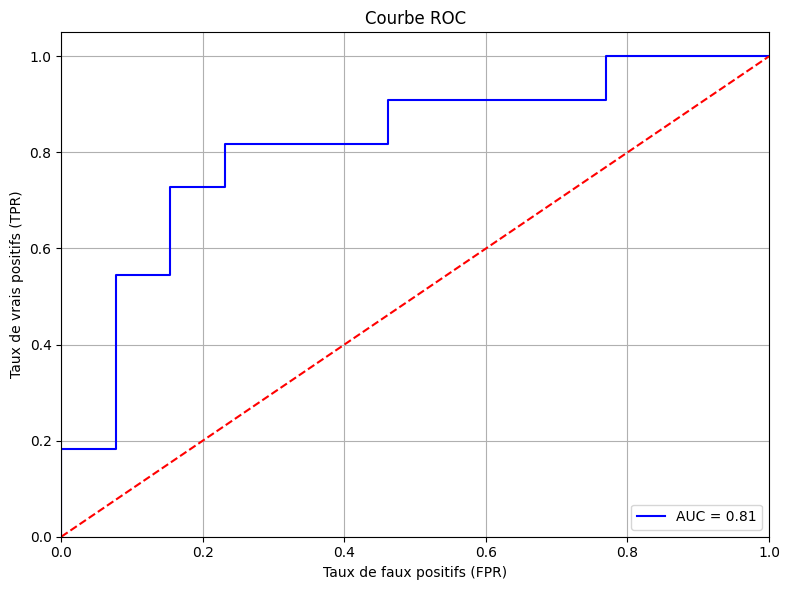

In [13]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


# Coefficients du modèle
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': best_logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nCoefficients du modèle :")
print(coefficients)
# Visualisation des coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title("Coefficients du modèle de régression logistique")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#Courbe ROC et AUC
# Calcul des probabilités de prédiction
y_proba_grid = best_logreg.predict_proba(X_test_scaled)[:, 1]
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_grid)
# Calcul de l'AUC
roc_auc = auc(fpr, tpr)  
# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonale
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

###  Analyse finale du modèle régularisé (Logistic Regression + GridSearchCV)

Après optimisation des hyperparamètres par validation croisée (GridSearchCV), le modèle final de régression logistique a été évalué sur le jeu de test. Voici les principaux résultats :

####  Matrice de confusion :
- Le modèle détecte **8 vrais positifs** sur 11, et **11 vrais négatifs** sur 13.
- Cela montre un bon équilibre entre sensibilité et spécificité.

#### Coefficients du modèle :
- Les variables ayant le plus d'influence sont :
  - **Insulin_log** (positif) → facteur prédictif fort de la classe 1 (cancer),
  - **BMI** (positif) et **Age** (positif),
  - **Glucose**, **HOMA_log** et **Resistin_log** (coefficients négatifs) → indicateurs protecteurs selon le modèle.
- Ces coefficients sont **interprétables** grâce à la régression linéaire et confirment des liens biomédicaux plausibles.

#### Courbe ROC :
- L'aire sous la courbe (**AUC**) est de **0.81**, indiquant une **bonne capacité de discrimination** du modèle.
- La courbe ROC montre que le modèle est capable de bien différencier les patients atteints ou non de cancer.

---

Ces résultats sont encourageants, d'autant plus que le dataset est **petit**.  
Le modèle a été rigoureusement entraîné avec :
- Prétraitement des variables (log + standardisation),
- Validation croisée,
- Optimisation par régularisation (`l1`/`l2` via `GridSearchCV`),
- Évaluation finale sur un jeu de test.

**Conclusion** : La régression logistique régularisée est un **modèle performant, stable et interprétable**, bien adapté à cette tâche de détection binaire.



Comparaison des modèles :
                   Accuracy  F1-score    AUC
Modèle simple         0.792     0.783  0.811
Modèle CV             0.792     0.783  0.811
Modèle régularisé     0.792     0.762  0.811


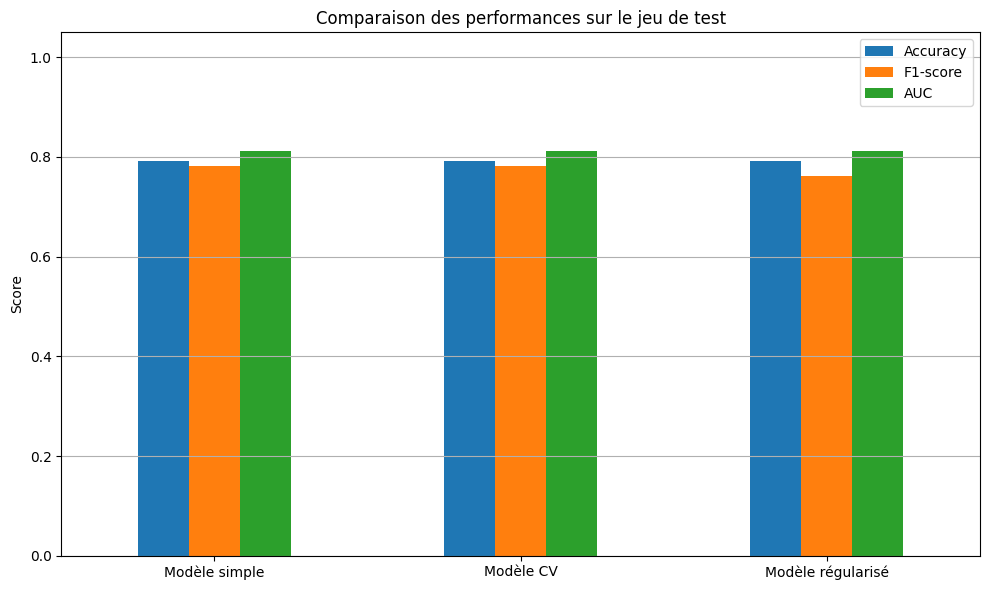

In [17]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Liste des modèles à comparer
model_names = ["Modèle simple", "Modèle CV", "Modèle régularisé"]
models = [logreg_simple, logreg_cv, best_logreg]

# Dictionnaires pour stocker les résultats
results = {
    "Accuracy": [],
    "F1-score": [],
    "AUC": []
}

# Évaluation de chaque modèle
logreg_cv.fit(X_train_scaled, y_train)

for model in models:
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["F1-score"].append(f1_score(y_test, y_pred))
    results["AUC"].append(roc_auc_score(y_test, y_proba))

# Affichage sous forme de DataFrame
df_results = pd.DataFrame(results, index=model_names)
print("\nComparaison des modèles :")
print(df_results.round(3))

# Visualisation
df_results.plot(kind='bar', figsize=(10, 6))
plt.title("Comparaison des performances sur le jeu de test")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
